In [74]:
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2024-10-19 20:19:17--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv.6’

tmdb_5000_movies.cs 100%[===================>]   5.43M  --.-KB/s    in 0.08s   

2024-10-19 20:19:17 (67.3 MB/s) - ‘tmdb_5000_movies.csv.6’ saved [5698602/5698602]



In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import nltk

nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)

True

In [76]:
df = pd.read_csv(
    "tmdb_5000_movies.csv",
    usecols=["title", "overview", "genres", "keywords", "tagline"],
)
df = df.dropna()
df[['title', 'overview', 'tagline', 'genres', 'keywords']]

,title,overview,tagline,genres,keywords
0,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",Enter the World of Pandora.,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""na..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.","At the end of the world, the adventure begins.","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""caly..."
2,Spectre,"A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.",A Plan No One Escapes,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"": ""united kingdom""}]"
3,The Dark Knight Rises,"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a cit...",The Legend Ends,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name"": ""Thriller""}]","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853, ""name"": ""crime fighter""}, {""id"": 949, ""name"": ""terrorist""}, {""id"": 1308, ""name"": ""secret identity""}, {""id"": 1437, ""name"": ""burglar""}, {""id"": 3051, ""name"": ""hostage drama""}, {""id"": 3562, ""name"": ""time bomb""}, {""id"": 6969, ""name"": ""gotham city""}, {""id"": 7002, ""name"": ""vigilante""}, {""id"": 9665, ""name"": ""cover-up""}, {""id"": 9715, ""name"": ""superhero""}, ..."
4,John Carter,"John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands.","Lost in our world, found in another.","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 878, ""name"": ""Science Fi

In [77]:
def genres_and_keywords_to_string(row):
    genres = " ".join(
        [genre["name"].replace(" ", "") for genre in json.loads(row["genres"])]
    )
    keywords = " ".join(
        [keyword["name"].replace(" ", "") for keyword in json.loads(row["keywords"])]
    )
    tagline = row["tagline"] if pd.notnull(row["tagline"]) else ""
    return f"{genres} {keywords} {tagline}"


df["genres_keywords_tagline"] = df.apply(genres_and_keywords_to_string, axis=1)
df[["title", "overview", "genres_keywords_tagline"]]

,title,overview,genres_keywords_tagline
0,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d Enter the World of Pandora.
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.","Adventure Fantasy Action ocean drugabuse exoticisland eastindiatradingcompany loveofone'slife traitor shipwreck strongwoman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger At the end of the world, the adventure begins."
2,Spectre,"A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.",Action Adventure Crime spy basedonnovel secretagent sequel mi6 britishsecretservice unitedkingdom A Plan No One Escapes
3,The Dark Knight Rises,"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a cit...",Action Crime Drama Thriller dccomics crimefighter terrorist secretidentity burglar hostagedrama timebomb gothamcity vigilante cover-up superhero villainess tragichero terrorism destruction catwoman catburglar imax flood criminalunderworld batman The Legend Ends
4,John Carter,"John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands.","Action Adventure ScienceFiction basedonnovel mars medallion spacetravel princess alien steampunk martian escape edgarriceburroughs alienrace superhumanstrength marscivilization swordandplanet 19thcentury 3d Lost in our world, found in another."
...,...,...,...
4795,Bang,"A young woman in L.A. is having a bad day: she's evicted, an audition ends with a producer furious she won't trade sex for the part, and a policeman nabs her for something she didn't do, demanding fellatio to release her. She snaps, grabs his gun, takes his uniform, and leaves him cuffed to a tree where he's soon having a defenseless chat with a homeless man. She takes off on the cop's motorcy...",Drama gang audition policefake homeless actress Sometimes you've got to break the rules
4796,Primer,"Friends/fledgling entrepreneurs invent a device in their garage that reduces the apparent mass of any object placed inside it, but they accidentally discover that it has some highly unexpected capabilities -- ones that could enable them to do and to have seemingly anything they want. Taking advantage of this unique opportunity is the first challenge they face. Dealing with the consequences is ...",ScienceFiction Drama Thriller distrust garage identitycrisis timetravel timemachine mathematics independentfilm paradox mechanicalengineering What happens if it actually works?
4798,El Mariachi,"El Mariachi just wants to play his guitar and carry on the family tradition. Unfortunately, the town he tries to find work in has another visitor...a killer who carries his guns in a guitar case. The drug lord and his henchmen mistake El Mariachi for the

In [78]:
df["combined_text"] = df["overview"] + " " + df["genres_keywords_tagline"]
df[["title", "combined_text"]]

,title,combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsou..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems. Adventure Fantasy Action ocean drugabuse exoticisland eastindiatradingcompany loveofone'slife traitor shipwreck strongwoman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger At the end of t..."
2,Spectre,"A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE. Action Adventure Crime spy basedonnovel secretagent sequel mi6 britishsecretservice unitedkingdom A Plan No One Escapes"
3,The Dark Knight Rises,"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a cit..."
4,John Carter,"John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands. Action Adventure ScienceFiction basedonnovel mars med..."
...,...,...
4795,Bang,"A young woman in L.A. is having a bad day: she's evicted, an audition ends with a producer furious she won't trade sex for the part, and a policeman nabs her for something she didn't do, demanding fellatio to release her. She snaps, grabs his gun, takes his uniform, and leaves him cuffed to a tree where he's soon having a defenseless chat with a homeless man. She takes off on the cop's motorcy..."
4796,Primer,"Friends/fledgling entrepreneurs invent a device in their garage that reduces the apparent mass of any object placed inside it, but they accidentally discover that it has some highly unexpected capabilities -- ones that could enable them to do and to have seemingly anything they want. Taking advantage of this unique opportunity is the first challenge they face. Dealing with the consequences is ..."
4798,El Mariachi,"El Mariachi just wants to play his guitar and carry on the family tradition. Unfortunately, the town he tries to find work in has another visitor...a killer who carries his guns in a guitar case. The drug lord and his henchmen mistake El Mariachi for the killer, Azul, and chase him around town trying to kill him and get his guitar case. Action Crime Thriller unitedstates–mexicobarrier legs arm..."
4799,Newlyweds,A newlywed couple's honeymoon is upended by the arrivals of their respective sisters. Comedy Romance A newlywed couple's honeymoon is upended by the arrivals of their respective sisters.


In [79]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    clean_text = text.lower()
    words = [
        lemmatizer.lemmatize(word)
        for word in word_tokenize(clean_text)
        if word.isalnum() and word not in stop_words
    ]
    return " ".join(words)


df["clean_combined_text"] = df["combined_text"].apply(clean_text)
df[['title', 'combined_text', 'clean_combined_text']]

,title,combined_text,clean_combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsou...",22nd century paraplegic marine dispatched moon pandora unique mission becomes torn following order protecting alien civilization action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d enter world pandora
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems. Adventure Fantasy Action ocean drugabuse exoticisland eastindiatradingcompany loveofone'slife traitor shipwreck strongwoman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger At the end of t...",captain barbossa long believed dead come back life headed edge earth turner elizabeth swann nothing quite seems adventure fantasy action ocean drugabuse exoticisland eastindiatradingcompany traitor shipwreck strongwoman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger end world adventure begin
2,Spectre,"A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE. Action Adventure Crime spy basedonnovel secretagent sequel mi6 britishsecretservice unitedkingdom A Plan No One Escapes",cryptic message bond past sends trail uncover sinister organization battle political force keep secret service alive bond peel back layer deceit reveal terrible truth behind spectre action adventure crime spy basedonnovel secretagent sequel mi6 britishsecretservice unitedkingdom plan one escape
3,The Dark Knight Rises,"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a cit...",following death district attorney harvey dent batman assumes responsibility dent crime protect late attorney reputation subsequently hunted gotham city police department eight year later batman encounter mysterious selina kyle villainous bane new terrorist leader overwhelms gotham finest dark knight resurfaces protect city branded enemy action crime drama thriller dccomics crimefighter terrori...
4,John Carter,"John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands. Action Adventure ScienceFiction basedonnovel mars med...",john carter former military captain inexplicably transported mysterious exotic planet barsoom mar reluctantly becomes embroiled epic conflict world brink collapse carter rediscovers humanity realizes survival barsoom people rest hand action adventure sciencefiction basedonnovel mar medallion spacetravel princess alien steampunk martian escape edgarriceburroughs alienrace superhumanstrength mar...
...,...,...,...
4795,Bang,"A young woman in L.A. is having a bad day: she's evicted, an audi

In [80]:
pretrained_w2v = api.load("word2vec-google-news-300")
pretrained_glove = api.load("glove-wiki-gigaword-300")
pretrained_fasttext = api.load("fasttext-wiki-news-subwords-300")


def get_vector(text, model):
    words = text.split()
    word_vecs = [model[word] for word in words if word in model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(300)


df["word2vec_vector"] = df["clean_combined_text"].apply(
    lambda text: get_vector(text, pretrained_w2v)
)
df["glove_vector"] = df["clean_combined_text"].apply(
    lambda text: get_vector(text, pretrained_glove)
)
df["fasttext_vector"] = df["clean_combined_text"].apply(
    lambda text: get_vector(text, pretrained_fasttext)
)
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_combined_text"])
df["tfidf_vector"] = list(tfidf_matrix.toarray())
df[
    [
        "title",
        "clean_combined_text",
        "word2vec_vector",
        "glove_vector",
        "fasttext_vector",
        "tfidf_vector",
    ]
]

,title,clean_combined_text,word2vec_vector,glove_vector,fasttext_vector,tfidf_vector
0,Avatar,22nd century paraplegic marine dispatched moon pandora unique mission becomes torn following order protecting alien civilization action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d enter world pandora,"[0.06455814, 0.05200375, -0.011962891, 0.064015105, -0.09655762, 0.03670457, 0.04218382, -0.08796064, 0.035102397, 0.027239632, 0.0049124323, -0.11361874, -0.06201172, -0.009607651, -0.099105835, 0.062404856, -0.04814058, 0.05984048, 0.037750244, -0.013445686, -0.07837632, 0.00039224065, -0.021089442, -0.0077604405, -0.044854555, -0.025706572, -0.013128561, 0.11838666, 0.13635433, -0.0935274, ...","[-0.027988898, -0.022615276, -0.017876057, -0.16776188, -0.022771947, 0.10837383, -0.18092029, 0.06858022, 0.08638179, -0.8097184, 0.29239023, -0.08141127, 0.00968078, -0.10225411, -0.030600272, -0.028915282, 0.036086418, 0.04559978, -0.1726519, 0.105267964, -0.036328837, 0.2012511, 0.056974478, 0.23602629, 0.18863875, -0.08683818, 0.14231893, -0.017432224, -0.0062133335, 0.2051475, 0.11266345...","[-0.010888328, -0.02125517, 0.049644634, 0.021920884, -0.017013194, -0.013768945, -0.0008053718, -0.095039405, 0.025239931, 0.023325663, 0.004404137, -0.0203996, 0.0017359393, 0.010230467, -0.018316576, 6.838446e-05, 0.076035626, -0.019212237, 0.046824265, 0.02678149, 0.005041238, -0.017917357, 0.00830743, 0.056101512, -0.004365779, -0.018685132, -8.7220804e-05, 0.004078068, 0.017091183, 0.003...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16102681514187392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0793141980009087, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08970088229592638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31607729199018997, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back life headed edge earth turner elizabeth swann nothing quite seems adventure fantasy action ocean drugabuse exoticisland eastindiatradingcompany traitor shipwreck strongwoman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger end world adventure begin,"[0.070882164, 0.045965947, 0.01393821, 0.09197998, 0.008059877, 0.019081809, -0.02093136, -0.11799945, 0.110240586, 0.078964695, 0.032284822, -0.17010683, -0.045911383, -0.0035992246, -0.07720392, 0.10408066, 0.025861336, 0.0702265, 0.03304499, -0.053439517, 0.014606822, 0.038589016, 0.039045393, -0.06688158, 0.09013968, -0.029141514, -0.08885794, 0.07441295, 0.12369491, -0.06655884, -0.018179...","[-0.08289482, -0.09457336, 0.07866199, -0.07076832, 0.08988474, 0.08373062, -0.12701434, 0.014087046, 0.09391255, -0.80282724, 0.17791691, -0.09196868, -0.006386114, -0.09575689, -0.07289244, -0.0072690123, 0.07221631, -0.020596504, -0.06472242, 0.16571264, -0.03270689, 0.18286166, 0.14302231, 0.04048603, 0.04441417, -0.056388713, 0.07581004, -0.08979382, -0.018567175, 0.17959777, 0.034397285,...","[-0.012833232, -0.025485784, 0.019201852, 0.022032125, -0.010456595, -0.02272943, -0.0053630276, -0.110698335, 0.023780324, 0.03883174, -0.021546429, -0.03463082, 0.00096027134, -0.0041870335, -0.011924354, -0.0044365735, 0.08813279, -0.023947345, 0.055027086, 0.014937296, -0.018183207, -0.0089873, -0.012799913, 0.05720867, 0.010103923, -0.0153056765, 0.013910515, 0.0021855664, 0.011789071, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08769093122743954, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19834920099331038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15956969458988865, 0.24276172451480724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

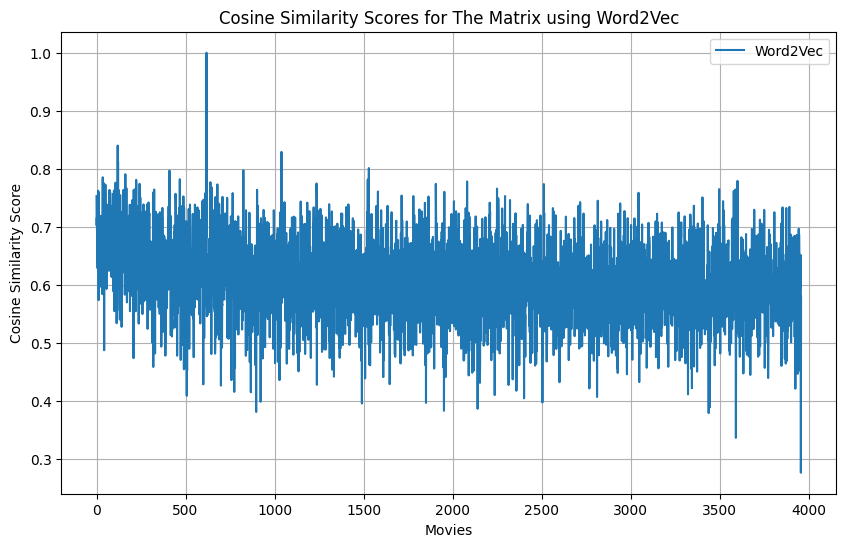

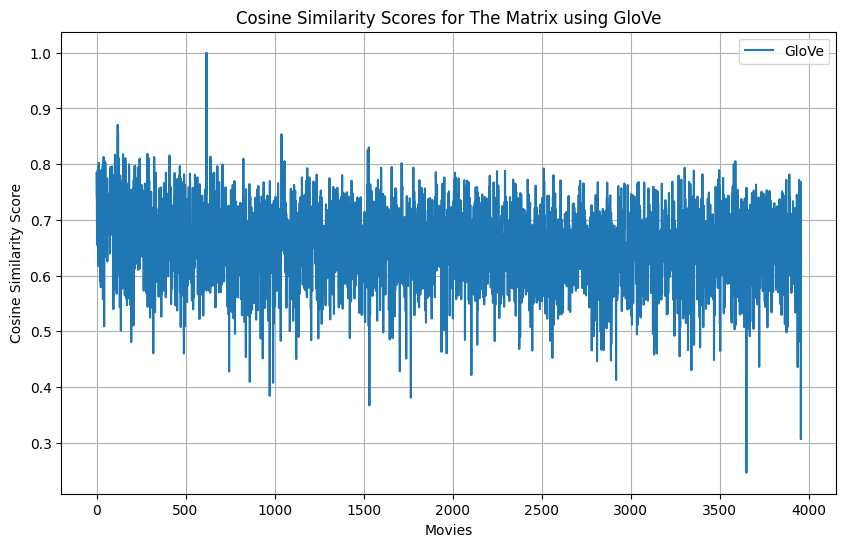

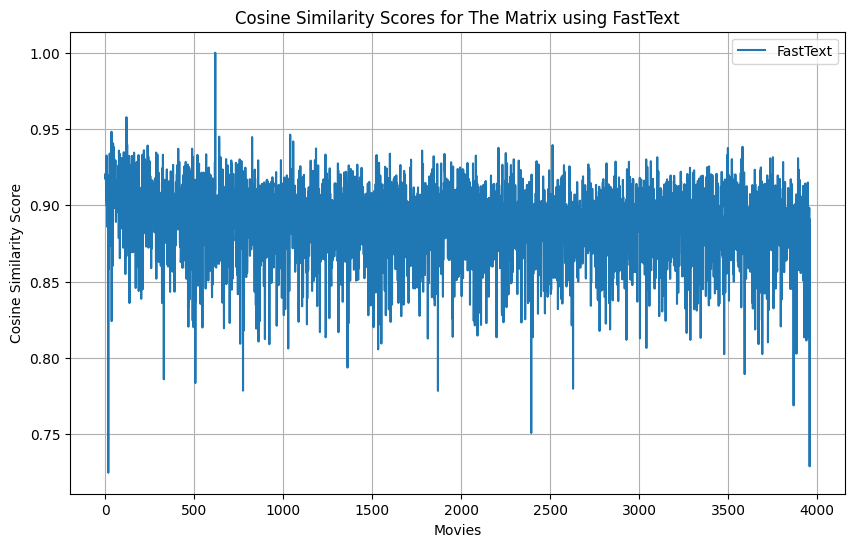

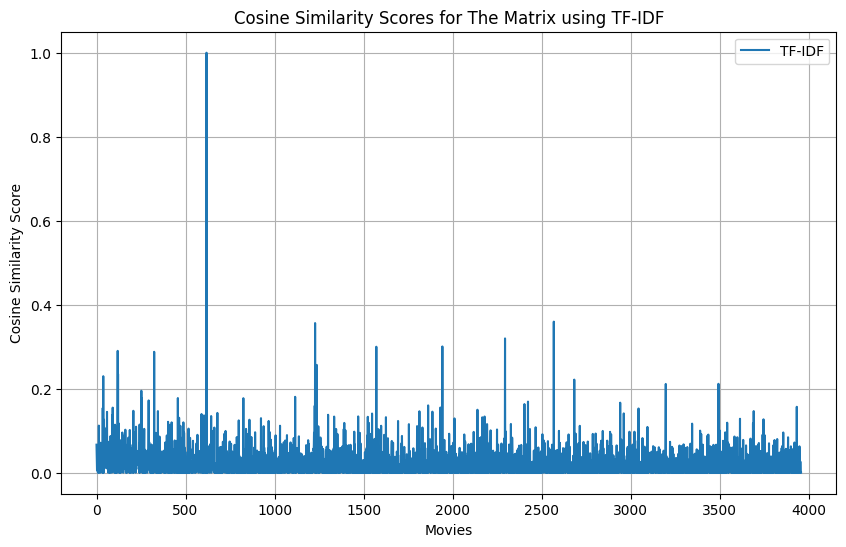

In [81]:
def plot_similarity_scores(title, vector_column, model_name):
    indices = pd.Series(df.index, index=df["title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        print(f"Movie titled '{title}' not found.")
        return

    query_vec = df.loc[idx, vector_column].reshape(1, -1)
    cosine_similarities = cosine_similarity(
        query_vec, np.vstack(df[vector_column].values)
    )
    scores = cosine_similarities.flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(scores, label=model_name)
    plt.title(f"Cosine Similarity Scores for {title} using {model_name}")
    plt.xlabel("Movies")
    plt.ylabel("Cosine Similarity Score")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_sorted_similarity_scores(title, vector_column, model_name):
    indices = pd.Series(df.index, index=df["title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        print(f"Movie titled '{title}' not found.")
        return

    query_vec = df.loc[idx, vector_column].reshape(1, -1)
    cosine_similarities = cosine_similarity(
        query_vec, np.vstack(df[vector_column].values)
    )
    scores = cosine_similarities.flatten()
    sorted_scores = scores[(-scores).argsort()]

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_scores, label=f"Sorted {model_name} Similarity Scores")
    plt.title(f"Cosine Similarity Scores for {title} (Sorted) using {model_name}")
    plt.xlabel("Movies (Sorted by Similarity)")
    plt.ylabel("Cosine Similarity Score")
    plt.legend()
    plt.grid(True)
    plt.show()


def get_recommendations(title, vector_column):
    indices = pd.Series(df.index, index=df["title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        return f"Movie titled '{title}' not found."

    query_vec = df.loc[idx, vector_column].reshape(1, -1)
    cosine_similarities = cosine_similarity(
        query_vec, np.vstack(df[vector_column].values)
    )

    sim_scores = list(enumerate(cosine_similarities[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]

    movie_indices = [i[0] for i in sim_scores]
    recommended_movies = df.iloc[movie_indices]["title"]

    return recommended_movies, sim_scores


def compare_recommendations(title):
    print(f"For the movie: {title}")

    models = {
        "Word2Vec": "word2vec_vector",
        "GloVe": "glove_vector",
        "FastText": "fasttext_vector",
        "TF-IDF": "tfidf_vector",
    }

    for model_name, vector_column in models.items():
        recommended_movies, sim_scores = get_recommendations(title, vector_column)
        if isinstance(recommended_movies, str):
            print(recommended_movies)
            continue
        print(f"\nMovies recommended using {model_name}:")
        for i, (movie, score) in enumerate(zip(recommended_movies, sim_scores), 1):
            print(f"{i}. {movie} - Score: {score[1]:.4f}")


query_film = "The Matrix"

plot_similarity_scores(query_film, "word2vec_vector", "Word2Vec")
plot_similarity_scores(query_film, "glove_vector", "GloVe")
plot_similarity_scores(query_film, "fasttext_vector", "FastText")
plot_similarity_scores(query_film, "tfidf_vector", "TF-IDF")

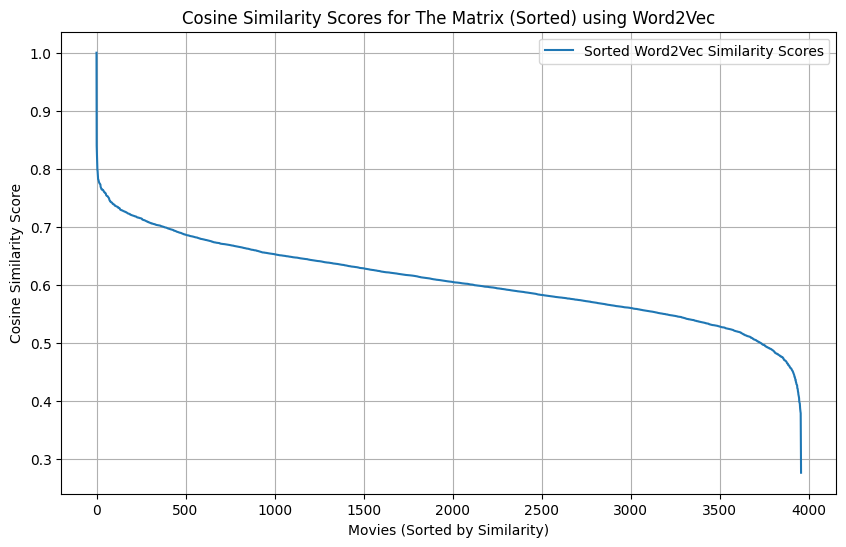

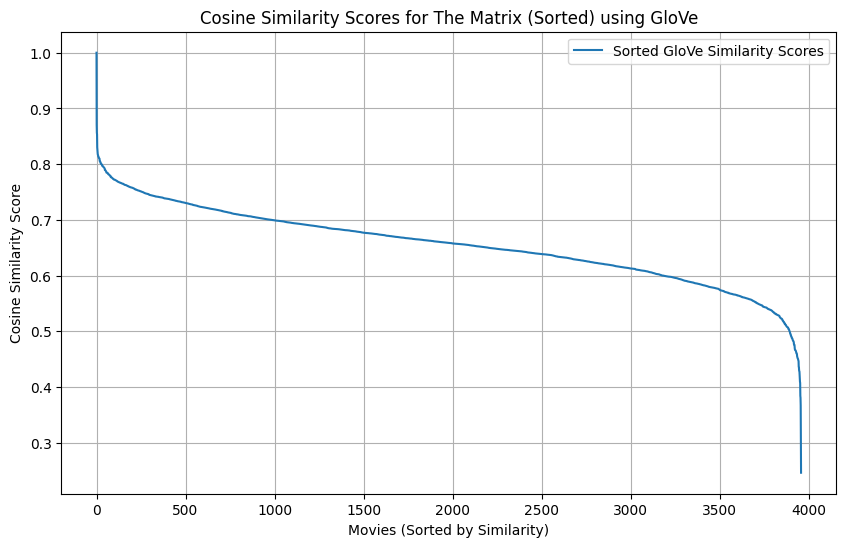

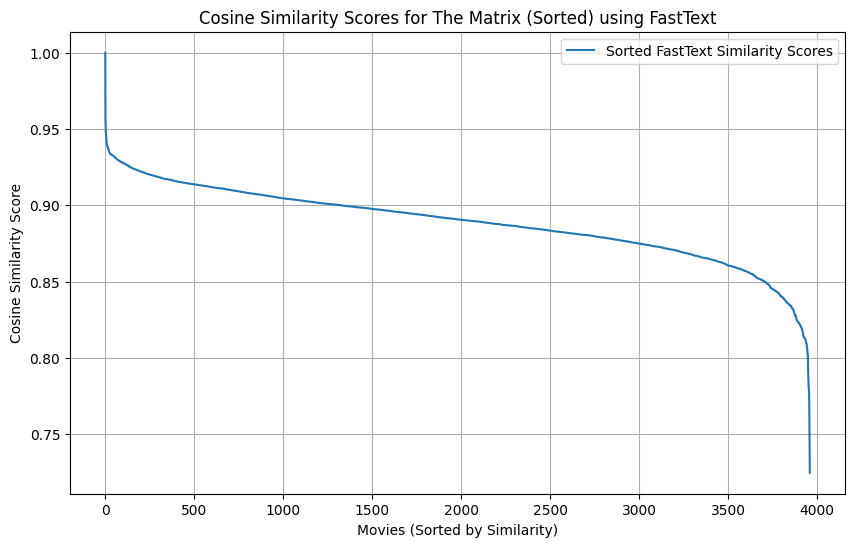

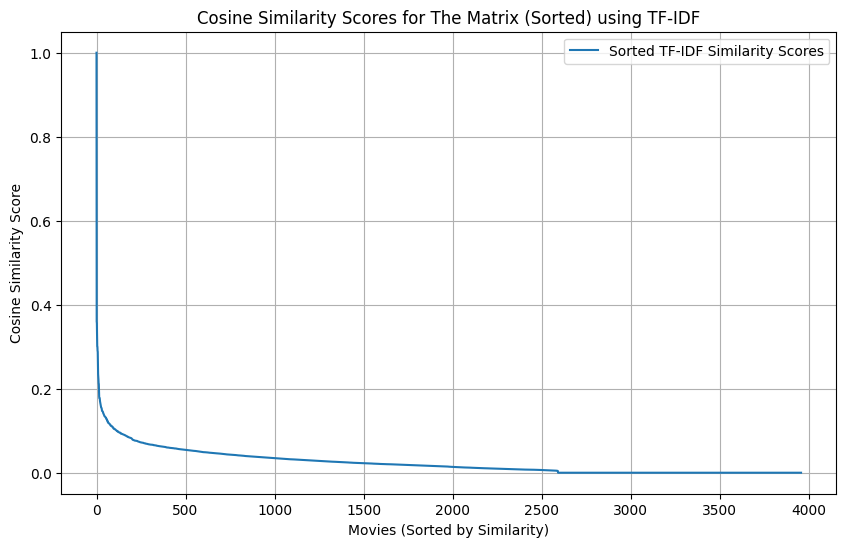

In [82]:
plot_sorted_similarity_scores(query_film, "word2vec_vector", "Word2Vec")
plot_sorted_similarity_scores(query_film, "glove_vector", "GloVe")
plot_sorted_similarity_scores(query_film, "fasttext_vector", "FastText")
plot_sorted_similarity_scores(query_film, "tfidf_vector", "TF-IDF")

In [83]:
compare_recommendations(query_film)

For the movie: The Matrix

Movies recommended using Word2Vec:
1. The Matrix Revolutions - Score: 0.8401
2. Dune - Score: 0.8292
3. The Matrix Reloaded - Score: 0.8136
4. 9 - Score: 0.8014
5. Æon Flux - Score: 0.7977

Movies recommended using GloVe:
1. The Matrix Revolutions - Score: 0.8705
2. The Matrix Reloaded - Score: 0.8563
3. Dune - Score: 0.8535
4. 9 - Score: 0.8301
5. Mortal Kombat: Annihilation - Score: 0.8252

Movies recommended using FastText:
1. The Matrix Revolutions - Score: 0.9577
2. The Matrix Reloaded - Score: 0.9529
3. Transformers: Age of Extinction - Score: 0.9482
4. Dune - Score: 0.9463
5. Resident Evil: Retribution - Score: 0.9450

Movies recommended using TF-IDF:
1. WarGames - Score: 0.3597
2. Hackers - Score: 0.3563
3. The Thirteenth Floor - Score: 0.3197
4. Pulse - Score: 0.3006
5. Antitrust - Score: 0.3000
